# Train different Neural Networks on a Traffic Sign Detection Dataset
https://cs231n.github.io/neural-networks-3/#sanitycheck\
https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/#h-cnn-model-building\
https://medium.com/towards-data-science/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d\
https://www.youtube.com/watch?v=r0RspiLG260\

In [2]:
# global imports
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from enum import Enum
from abc import ABC, abstractmethod
from typing import Optional
import random
import numpy as np
from PIL import Image
import yaml

### Data Loading
Load and select images from dataset folder, save images + annotations as entries in training, validation and test data

In [12]:
class DataType(Enum):
    TRAIN = 1
    TEST = 2
    VALID = 3

class Label:
    def __init__(self, raw_data: str) -> None:
        split_data = raw_data.split(' ')
        self.category = int(split_data[0])
        self.center_x, self.center_y, self.width, self.height = map(float, split_data[1:])

class Entry:
    def __init__(self, image: np.array, labels: list[Label], image_name: str) -> None:
        self.image = image
        self.labels = labels
        self.image_name = image_name


dataset_path = 'data/traffic-signs-detection'
info_file = os.path.join(dataset_path, 'car/data.yaml')
categories = yaml.load(open(info_file), Loader=yaml.FullLoader)['names']

# different setting depending on which task the model should have (single or multiclass, etc.)
img_size = 32
min_bounding_box_size = 0.3
only_single_label = True
forbidden_file_prefixes = ['FisheyeCamera', 'road']
grayscale = False

def load_image_data(type: DataType):
    data_path = os.path.join(dataset_path, 'car', type.name.lower())
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    entries = []
    files_in_folder = os.listdir(images_path)
    print(f'Scanning {len(files_in_folder)} entries from {images_path} and {labels_path}...')

    for image_name in files_in_folder:
        image = plt.imread(os.path.join(images_path, image_name))
        image = np.array(Image.fromarray(image).resize((img_size, img_size)))

        if grayscale:
            image = np.mean(image, axis=2)
        
        image = image / 255.0
        labels_raw = open(os.path.join(labels_path, image_name.replace('.jpg', '.txt'))).read().split('\n')
        labels = [Label(label) for label in labels_raw if label]

        if (
            only_single_label and len(labels) > 1
            or len(labels) == 0
            or any([image_name.startswith(prefix) for prefix in forbidden_file_prefixes])
            or any([label.width < min_bounding_box_size or label.height < min_bounding_box_size for label in labels])
        ):
            continue

        entries.append(Entry(image, labels, image_name))

    return entries

train_data = load_image_data(DataType.TRAIN)
validate_data = load_image_data(DataType.VALID)
test_data = load_image_data(DataType.TEST)

print(f'Loaded {len(train_data)} training images, {len(validate_data)} validation images and {len(test_data)} test images')

Scanning 3530 entries from data/traffic-signs-detection\car\train\images and data/traffic-signs-detection\car\train\labels...
Scanning 801 entries from data/traffic-signs-detection\car\valid\images and data/traffic-signs-detection\car\valid\labels...
Scanning 638 entries from data/traffic-signs-detection\car\test\images and data/traffic-signs-detection\car\test\labels...
Loaded 1747 training images, 450 validation images and 287 test images


### Data Visualization
Show random images and bounding boxes from loaded data

Displaying 6 random images from each of the following categories: Green Light, Speed Limit 100, Speed Limit 90, Stop


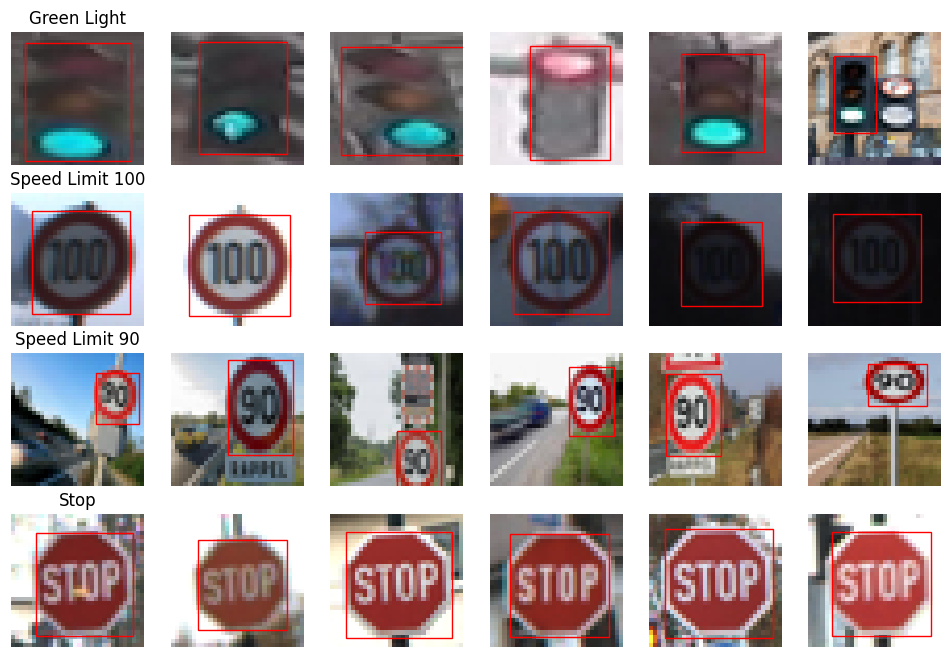

In [13]:
num_images = 6
categories_to_display = [0, 3, 13, 14]
fig, axs = plt.subplots(len(categories_to_display), num_images, figsize=(num_images * 2, len(categories_to_display) * 2))
print(f'Displaying {num_images} random images from each of the following categories: {", ".join([categories[category] for category in categories_to_display])}')

for idx, category in enumerate(categories_to_display):
    category_entries = [entry for entry in train_data if entry.labels[0].category == category]
    
    if len(category_entries) >= num_images:
        selected_entries = random.sample(category_entries, num_images)
    else:
        selected_entries = category_entries
    
    for i, entry in enumerate(selected_entries):
        axs[idx, i].imshow(entry.image, cmap='gray')
        axs[idx, i].axis('off')
        if i == 0:
            axs[idx, i].set_title(categories[category])
            
        for label in entry.labels:
            x = label.center_x * img_size
            y = label.center_y * img_size
            w = label.width * img_size
            h = label.height * img_size
            rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='r')
            axs[idx, i].add_patch(rect)

for ax in axs.flat:
    ax.axis('off')

plt.show()


### Utility functions
Because we sorted specific images out while loading the data, the validation and test data should be changed to match the class distribution of the training images again.

Additionally there is a helper function to split the data entries into images and labels.

In [14]:
def get_data(data: list[Entry]):
    np.random.shuffle(data)
    images = np.array([entry.image for entry in data])
    labels = np.array([entry.labels[0].category for entry in data])
    return images, labels

def print_category_distribution(labels):
    total = len(labels)
    distribution = {category: np.sum(labels == category) / total * 100 for category in np.unique(labels)}
    print(", ".join([f'{categories[cat]}: {dist:.2f}%' for cat, dist in distribution.items()]))

def get_balanced_data(source_data: list[Entry], target_distribution: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Resamples data to match a target distribution of categories.
    
    Args:
        source_data: List of entries to be resampled
        target_distribution: Array of target percentages for each category
        
    Returns:
        Tuple of (images, labels) with the desired distribution
    """
    # Get initial data
    np.random.shuffle(source_data)
    images = np.array([entry.image for entry in source_data])
    labels = np.array([entry.labels[0].category for entry in source_data])
    
    # Calculate current and target distributions
    n_categories = len(target_distribution)
    current_counts = np.array([np.sum(labels == i) for i in range(n_categories)])
    current_dist = current_counts / len(labels)
    
    # Calculate number of samples needed for each category
    target_size = len(labels)
    target_counts = (target_distribution * target_size).astype(int)
    
    # Initialize arrays for balanced dataset
    balanced_images = []
    balanced_labels = []
    
    # Resample each category
    for category in range(n_categories):
        category_indices = np.where(labels == category)[0]
        
        # If we need more samples than available, sample with replacement
        if target_counts[category] > len(category_indices):
            sampled_indices = np.random.choice(
                category_indices,
                size=target_counts[category],
                replace=True
            )
        # If we need fewer samples, sample without replacement
        else:
            sampled_indices = np.random.choice(
                category_indices,
                size=target_counts[category],
                replace=False
            )
            
        balanced_images.extend(images[sampled_indices])
        balanced_labels.extend(labels[sampled_indices])
    
    # Convert to numpy arrays and shuffle
    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)
    
    # Shuffle the balanced dataset
    shuffle_idx = np.random.permutation(len(balanced_images))
    balanced_images = balanced_images[shuffle_idx]
    balanced_labels = balanced_labels[shuffle_idx]
    
    return balanced_images, balanced_labels

# Calculate target distribution from training data
train_images, train_labels = get_data(train_data)
target_distribution = np.array([np.sum(train_labels == i) for i in range(len(categories))]) / len(train_labels)

# Resample validation and test data to match training distribution
validate_images, validate_labels = get_balanced_data(validate_data, target_distribution)
test_images, test_labels = get_balanced_data(test_data, target_distribution)

# Print distributions to verify
print(f'Category distribution in the training dataset ({len(train_images)} images):')
print_category_distribution(train_labels)
print(f'Category distribution in the validation dataset ({len(validate_images)} images):')
print_category_distribution(validate_labels)
print(f'Category distribution in the test dataset ({len(test_images)} images):')
print_category_distribution(test_labels)

# test_images, test_labels = get_data(test_data)
# validate_images, validate_labels = get_data(validate_data)
# train_images, train_labels = get_data(train_data)

Category distribution in the training dataset (1747 images):
Green Light: 1.66%, Red Light: 2.23%, Speed Limit 100: 6.41%, Speed Limit 110: 1.43%, Speed Limit 120: 7.84%, Speed Limit 20: 13.57%, Speed Limit 30: 12.19%, Speed Limit 40: 1.83%, Speed Limit 50: 9.33%, Speed Limit 60: 10.88%, Speed Limit 70: 12.59%, Speed Limit 80: 6.53%, Speed Limit 90: 1.37%, Stop: 12.14%
Category distribution in the validation dataset (443 images):
Green Light: 1.58%, Red Light: 2.26%, Speed Limit 100: 6.32%, Speed Limit 110: 1.35%, Speed Limit 120: 7.90%, Speed Limit 20: 13.77%, Speed Limit 30: 12.19%, Speed Limit 40: 1.81%, Speed Limit 50: 9.26%, Speed Limit 60: 10.84%, Speed Limit 70: 12.64%, Speed Limit 80: 6.55%, Speed Limit 90: 1.35%, Stop: 12.19%
Category distribution in the test dataset (279 images):
Green Light: 1.43%, Red Light: 2.15%, Speed Limit 100: 6.45%, Speed Limit 110: 1.43%, Speed Limit 120: 7.89%, Speed Limit 20: 13.62%, Speed Limit 30: 12.19%, Speed Limit 40: 1.79%, Speed Limit 50: 9.

### MLP Training
Summary: Overfitting horror, kept adding more dropout and regularization & simplifying network but still experiencing horrendous overfitting. Then changed the image resolution from 64x64 to 32x32 and min_bounding_box_size from 0.3 to 0.5 and now the model performs okay.

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(categories), activation='softmax'))
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
            train_images,
            train_labels,
            batch_size=32,
            epochs=120,
            validation_data=(validate_images, validate_labels))


Epoch 1/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1537 - loss: 2.8032 - val_accuracy: 0.3657 - val_loss: 2.1223
Epoch 2/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3090 - loss: 2.1900 - val_accuracy: 0.3725 - val_loss: 2.0302
Epoch 3/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3011 - loss: 2.1146 - val_accuracy: 0.4266 - val_loss: 1.9063
Epoch 4/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3411 - loss: 1.9620 - val_accuracy: 0.4108 - val_loss: 1.8156
Epoch 5/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3517 - loss: 1.8965 - val_accuracy: 0.4289 - val_loss: 1.8170
Epoch 6/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3729 - loss: 1.8736 - val_accuracy: 0.4063 - val_loss: 1.7718
Epoch 7/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3897 - loss: 1.7814 - val_accuracy: 0.4041 - val_loss: 1.7585
Epoch 8/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3720 - loss: 1.7757 - val_accuracy: 0.4221 - v

### CNN Training
Yesss! 90% val accuracy (still slight overfitting)
Idk if my network is too complex, it's inspired by a model for 43 different traffic signs, I reduced the layer sizes and increased regularization & dropout. BatchNormalization made the learning curve look weird.

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, AveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Create model
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, 
                    train_labels, 
                    epochs=60,
                    batch_size=32,
                    validation_data=(validate_images, validate_labels))


Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1786 - loss: 2.5409 - val_accuracy: 0.4176 - val_loss: 1.8995
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4142 - loss: 1.9037 - val_accuracy: 0.5734 - val_loss: 1.5340
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4694 - loss: 1.6081 - val_accuracy: 0.6005 - val_loss: 1.3624
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5518 - loss: 1.3691 - val_accuracy: 0.6501 - val_loss: 1.1682
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6050 - loss: 1.1802 - val_accuracy: 0.7043 - val_loss: 1.0038
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6757 - loss: 1.0143 - val_accuracy: 0.7336 - val_loss: 0.9640
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7150 - loss: 0.8633 - val_accuracy: 0.7607 - val_loss: 0.8706
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7552 - loss: 0.7848 - val_accuracy: 0.7923 - v

### Model Loading
Skip the training process above and instantly load a keras model from disk

In [20]:
from tensorflow.keras.saving import load_model
model = load_model('models/cnn.keras')

### Model Evaluation

In [27]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8707 - loss: 1.0445 
Accuracy: 87.10%


### Training Visualization

Text(0, 0.5, 'Genauigkeit')

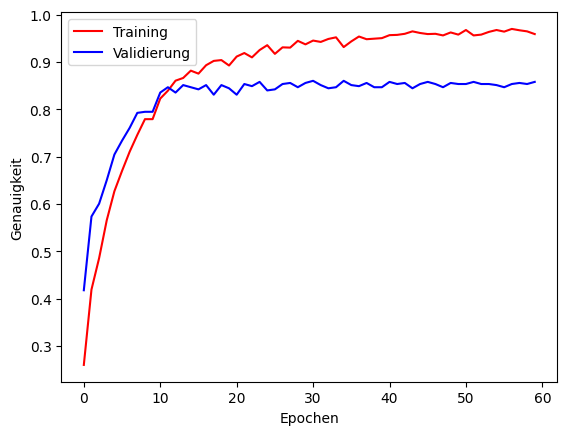

In [28]:
plt.plot(history.history['accuracy'], color='red', label='Training')
plt.plot(history.history['val_accuracy'], color='blue', label='Validierung')
plt.legend()
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
# plt.savefig('media/cnn_training.png')
# model.save('models/model_name.keras')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


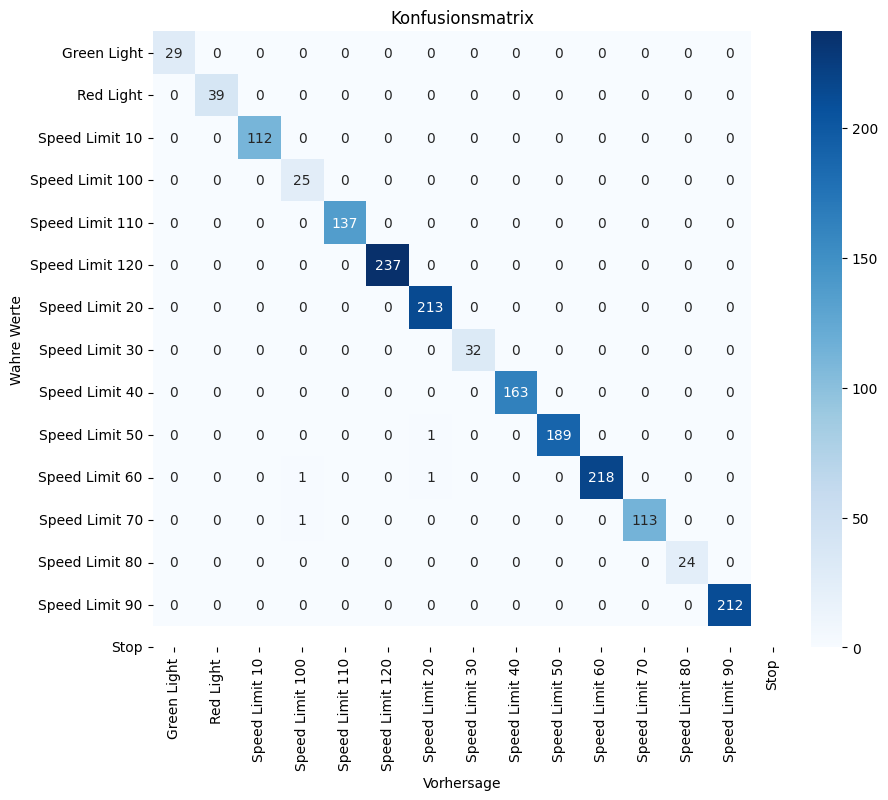

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(train_images)
conf_matrix = confusion_matrix(train_labels, np.argmax(predictions, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Vorhersage')
plt.ylabel('Wahre Werte')
plt.title('Konfusionsmatrix')
plt.show()

### Model Visualization
Displays each layer, filter and output with matplotlib

In [ ]:
from IPython.display import clear_output
import os
import shutil

def reshape_to_aspect(arr, aspect_ratio):
    """
    Reshapes a 1D numpy array into a 2D grid that best matches the desired aspect ratio.
    Adds padding (zeros) if necessary to fill the grid.
    
    Parameters:
    arr (numpy.ndarray): 1D input array.
    aspect_ratio (tuple): Desired aspect ratio as (width, height).
    
    Returns:
    numpy.ndarray: 2D reshaped array with padding if necessary.
    """
    if arr.size == 0:
        return np.zeros((0, 0))
    
    w, h = aspect_ratio
    target_ratio = w / h
    N = arr.size
    
    # Calculate ideal number of rows based on target ratio
    rows_ideal = np.sqrt(N / target_ratio)
    
    # Determine the range of rows to check around the ideal value
    min_row = max(1, int(np.floor(rows_ideal)) - 3)
    max_row = int(np.ceil(rows_ideal)) + 3
    
    best_diff = float('inf')
    best_pad = float('inf')
    best_shape = (1, N)  # Default shape, will be updated
    
    for row in range(min_row, max_row + 1):
        if row == 0:
            continue
        cols = (N + row - 1) // row  # Ceiling division
        actual_ratio = cols / row
        ratio_diff = abs(actual_ratio - target_ratio)
        padding = row * cols - N
        
        # Update best candidate if current is better
        if (ratio_diff < best_diff) or (ratio_diff == best_diff and padding < best_pad):
            best_diff = ratio_diff
            best_pad = padding
            best_shape = (row, cols)
    
    # Pad the array with zeros to fit the desired shape
    padded = np.pad(arr, (0, best_shape[0] * best_shape[1] - N), mode='constant')
    
    return padded.reshape(best_shape)

def save_model_layer_images(test_image, save_path='media/model'):
    print(f'Saving model layers as images in {save_path}...')

    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    
    os.mkdir(save_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image[0])
    plt.axis('off')
    plt.savefig(os.path.join(save_path, 'input_image.png'), bbox_inches='tight')
    plt.clf()

    for i, layer in enumerate(model.layers):
        layer_visible = False

        if isinstance(layer, Conv2D):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            filters = layer.get_weights()[0]
            n_filters = filters.shape[3]
            
            height = 20
            fig, axs = plt.subplots(n_filters, 2, figsize=(height / n_filters * 2 + 1, height))
            
            # axs[0, 0].set_title(f'Gewichte')
            for j in range(n_filters):
                filter_viz = np.mean(filters[:, :, :, j-1], axis=2)
                axs[j, 0].imshow(filter_viz, cmap='gray')
                axs[j, 0].axis('off')
            
            # axs[0, 1].set_title(f'Output')
            for j in range(n_filters):
                axs[j, 1].imshow(output[0, :, :, j], cmap='gray')
                axs[j, 1].axis('off')
            
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.tight_layout(h_pad=height / n_filters * 0.5)
            
        elif isinstance(layer, (MaxPooling2D, AveragePooling2D)):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            n_outputs = output.shape[-1]
            
            height = 20
            fig, axs = plt.subplots(n_outputs, 1, figsize=(height / n_outputs * 2, height))
            
            for j in range(n_outputs):
                axs[j].imshow(output[0, :, :, j], cmap='gray' if output.shape[-1] != 3 else ['Reds', 'Greens', 'Blues'][j])
                axs[j].axis('off')
            
            plt.tight_layout(h_pad=height / n_outputs * 0.5)
        
        elif i == len(model.layers) - 1:
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            fig, ax = plt.subplots(1, 1, figsize=(2, 8))
            ax.barh(np.arange(len(output[0])), output[0])
            ax.set_yticks(np.arange(len(output[0])))
            ax.set_yticklabels([categories[i].replace('Speed ', '') for i in range(len(output[0]))], rotation=45, ha='right')
            plt.tight_layout()
            
        elif isinstance(layer, Dense):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            image = reshape_to_aspect(output[0], (1, len(output[0]) // 2))
            fig, ax = plt.subplots(figsize=(2, 20))
            plt.axis('off')
            plt.imshow(image, cmap='gray')
        
        if layer_visible:
            plt.savefig(os.path.join(save_path, f'layer_{i}'), bbox_inches='tight')
            plt.clf()
    
    print(f'Saved model layers as images in {save_path}!')

def plot_model_from_saved_images(save_path='media/model'):
    visible_layers = [(i, layer) for i, layer in enumerate(model.layers) 
                  if isinstance(layer, (MaxPooling2D, AveragePooling2D, Conv2D, Dense))]

    fig, ax = plt.subplots(1, len(visible_layers) + 1, figsize=(20, 15))
    ax[0].imshow(plt.imread(os.path.join(save_path, 'input_image.png')))
    ax[0].axis('off')

    for j, (i, layer) in enumerate(visible_layers):
        ax[j + 1].imshow(plt.imread(os.path.join(save_path, f'layer_{i}.png')))
        ax[j + 1].axis('off')

        if isinstance(layer, Conv2D):
           pass
            
        elif isinstance(layer, (MaxPooling2D, AveragePooling2D)):
            pass
        
        elif i == len(model.layers) - 1:
            pass
            
        elif isinstance(layer, Dense):
            pass
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()
            
    
def plot_model(test_image):
    clear_output(wait=True)
    print(model.summary())
    save_model_layer_images(test_image)
    plot_model_from_saved_images()
    


# find images from validation set that are misclassified
# misclassified = []
# for i, (image, label) in enumerate(zip(validate_images, validate_labels)):
#     prediction = model.predict(image[np.newaxis, ...])
#     predicted_label = np.argmax(prediction)
#     if predicted_label != label or True:
#         misclassified.append((image, label, predicted_label))
#         visualize_model(np.array([image]))
#         break
#         input('Weiter mit Enter')

stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]
test_image = np.array([stop_signs[8].image])

plot_model(test_image)
    

### Example predictions
Show the model's guesses on different images from the dataset

In [ ]:
from IPython.display import clear_output

only_misclassified = True
skipped = 0
for entry in validate_data:
    label = model.predict(np.array([entry.image]), verbose=0)[0].argmax()
    if label == entry.labels[0].category and only_misclassified:
        skipped += 1
        continue
    
    if only_misclassified:
        print(f'Skipped: {skipped} correctly classified images')
        skipped = 0
    
    plt.imshow(entry.image, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted: {categories[label]}, Actual: {categories[entry.labels[0].category]}')
    plt.show()
    input('Press enter to continue...')
    clear_output(wait=True)



___
## Image Experiments

### Convolution

In [ ]:
def apply_filter(image: np.array, filter: np.array, stride: int = 1)->np.array:
    image_copy = deepcopy(image)
    filter_size = filter.shape[0]
    image_size = image.shape[0]
    for i in range(0, image_size - filter_size + 1, stride):
        for j in range(0, image_size - filter_size + 1, stride):
            image[i:i + filter_size, j:j + filter_size] = (image_copy[i:i + filter_size, j:j + filter_size] * filter).sum()
    
    return image


stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]
grayscale_img = np.array(stop_signs[8].image).sum(axis=2) / 3
vertical_edge_filter = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
horizontal_edge_filter = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
laplace_edge_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
# plt.imsave('media/Stoppschild_laplace.png', grayscale_img, cmap='gray')

horizontal = apply_filter(deepcopy(grayscale_img),  horizontal_edge_filter, stride=1)
laplace = apply_filter(deepcopy(grayscale_img), laplace_edge_filter, stride=1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(horizontal, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Horizontale Kanten')

axs[1].imshow(laplace, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Laplace-Filter')

### Show how an image is made out of numbers

In [ ]:
stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]

size = 14
grayscale_img = np.array(stop_signs[8].image).sum(axis=2) / 3
scaled_img = np.array(Image.fromarray(grayscale_img).resize((size, size)))
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(grayscale_img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original (Schwarz-Weiß)')

axs[1].imshow(scaled_img, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Skaliert auf 14x14 Pixel')

axs[2].imshow(scaled_img, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Helligkeitswerte')

for i in range(size):
    for j in range(size):
        axs[2].text(j, i, f'{scaled_img[i, j]:.2f}', ha='center', va='center', color='black' if scaled_img[i, j] > 0.5 else 'white', fontsize=7)

plt.show()
